In [42]:
IS_KAGGLE = False

if IS_KAGGLE:
    INPUT_FOLDER = '/kaggle/input/linking-writing-processes-to-writing-quality'
else:
    INPUT_FOLDER = '../data'

In [43]:
import pandas as pd
import numpy as np

In [44]:
df_raw_train = pd.read_csv(f'{INPUT_FOLDER}/train_logs.csv')
df_raw_test = pd.read_csv(f'{INPUT_FOLDER}/test_logs.csv')

df_raw_train.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [45]:
df_raw = pd.concat((df_raw_train, df_raw_test)).reset_index(False)

**id** - The unique ID of the essay

**event_id** - The index of the event, ordered chronologically

**down_time** - The time of the down event in milliseconds

**up_time** - The time of the up event in milliseconds

**action_time** - The duration of the event (the difference between down_time and up_time)

**activity** - The category of activity which the event belongs to

- **Nonproduction** - The event does not alter the text in any way

- **Input** - The event adds text to the essay

- **Remove/Cut** - The event removes text from the essay

- **Paste** - The event changes the text through a paste input

- **Replace** - The event replaces a section of text with another string

- **Move From [x1, y1] To [x2, y2]** - The event moves a section of text spanning character index x1, y1 to a new location x2, y2

**down_event** - The name of the event when the key/mouse is pressed

**up_event** - The name of the event when the key/mouse is released

**text_change** - The text that changed as a result of the event (if any)

**cursor_position** - The character index of the text cursor after the event

**word_count** - The word count of the essay after the event

In [46]:
# Creating a new df based on the number of essays
# More features (columns) will be added to this df

df = pd.DataFrame({
    'id': df_raw["id"].unique()
})
df['is_test'] = df['id'].isin(df_raw_test['id'].unique())
df

,id,is_test
0,001519c8,False
1,0022f953,False
2,0042269b,False
3,0059420b,False
4,0075873a,False
...,...,...
2469,ffec5b38,False
2470,fff05981,False
2471,0000aaaa,True
2472,2222bbbb,True


In [47]:
# Calculating the final word count for each essay
df_word = df_raw.groupby("id")['word_count'].max()
df = pd.merge(df, df_word, on="id", how="left")

In [48]:
# Turning milliseconds into minutes
df_raw['current_min'] = df_raw["down_time"]//60000

In [49]:
#Counting the number of events per essay
df_event = df_raw.groupby("id")['event_id'].count()

df = pd.merge(df, df_event, on="id", how="left")
df = df.rename(columns={"event_id": "event_count"})

In [50]:
# Calculating the time spend on writing the essay
df_time = df_raw.groupby("id")['current_min'].max()
df = pd.merge(df, df_time, on="id", how="left")
df = df.rename(columns={"current_min": "writing_time_min"})

In [51]:
# Calculating events per minute
df['events_per_min'] = df["event_count"] / df['writing_time_min']

In [52]:
# Calculating the number of TEXT changes made during the writing process
filter_text_change = df_raw["text_change"]!="NoChange"
df_filtered = df_raw[filter_text_change]
df_text_change = df_filtered.groupby("id")['text_change'].count()

df = pd.merge(df, df_text_change, on="id", how="left")

In [53]:
df = df.rename(columns={"text_change": "text_change_count"})

In [54]:
# Calculating text changes per minute
df['text_changes_per_min'] = df["text_change_count"] / df['writing_time_min']

In [55]:
# Calculating the number of sentences (based on the number of full stops)
sentence_filter = df_raw[(df_raw["text_change"].str.match('\.')) & (df_raw['activity'] != 'Remove/Cut')] 
sentence_filter = df_raw[df_raw["up_event"] == '.']
df_sentence_count = sentence_filter.groupby("id")['text_change'].count()

df = pd.merge(df, df_sentence_count, on="id", how="left")

In [56]:
df = df.rename(columns={"text_change": "sentence_count"})

In [57]:
# Calculating total number of different activities
for activity in ['Input', 'Remove/Cut', 'Paste', 'Replace', 'Nonproduction']:
    df_activity_count = df_raw[df_raw['activity'] == activity].groupby("id")['activity'].count()
    column_name = f'{activity}_count'
    df_activity_count.name = column_name
    df = pd.merge(df, df_activity_count, on="id", how="left")
    df[column_name] = df[column_name].fillna(0)

In [58]:
# Pauses
df_raw['IKI'] = df_raw['down_time'] - df_raw.groupby('id')['up_time'].shift(1)
df_raw['IKI'] = df_raw['IKI'].fillna(0)
df_raw['IKI'] = df_raw['IKI'].clip(0)

PAUSE_THRESHOLD = 2000

# Total number of pauses (over 2000 ms) during writing process
pauses_count = df_raw[df_raw['IKI'] > PAUSE_THRESHOLD].groupby('id')['IKI'].count()
pauses_count.name = 'pauses_count'
df = pd.merge(df, pauses_count, on="id", how="left")

In [59]:
# Average duration of a pause
pauses_mean_duration = df_raw[df_raw['IKI'] > PAUSE_THRESHOLD].groupby('id')['IKI'].mean().round(0)
pauses_mean_duration.name = 'pause_mean_duration'
df = pd.merge(df, pauses_mean_duration, on="id", how="left")

In [60]:
# Calculating total time of pauses
pauses_time_sum = df_raw[df_raw['IKI'] > PAUSE_THRESHOLD].groupby('id')['IKI'].sum()
pauses_time_sum.name = 'pauses_time_sum'
df = pd.merge(df, pauses_time_sum, on="id", how="left")

In [61]:
# Calculating writing time in ms
writing_time_ms = df_raw.groupby('id')['up_time'].max()
writing_time_ms.name = 'writing_time_ms'
df = pd.merge(df, writing_time_ms, on="id", how="left")

In [62]:
# Average number of pauses per minute
df['pause_per_min'] = (df["pauses_count"] / df['writing_time_min']).round(2)

# Proportion of pauses during the writing process
df['pauses_share'] = (df["pauses_time_sum"] / df['writing_time_ms']).round(2)

In [64]:
df

,id,is_test,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min,sentence_count,Input_count,Remove/Cut_count,Paste_count,Replace_count,Nonproduction_count,pauses_count,pause_mean_duration,pauses_time_sum,writing_time_ms,pause_per_min,pauses_share
0,001519c8,False,256,2557,30,85.233333,2437,81.233333,21.0,2010,417.0,0.0,7.0,120.0,124.0,9537.0,1182600.0,1801969,4.13,0.66
1,0022f953,False,323,2454,29,84.620690,2200,75.862069,15.0,1938,260.0,1.0,1.0,254.0,80.0,14678.0,1174268.0,1788969,2.76,0.66
2,0042269b,False,404,4136,29,142.620690,3961,136.586207,21.0,3515,439.0,0.0,7.0,175.0,77.0,14431.0,1111167.0,1771669,2.66,0.63
3,0059420b,False,206,1556,23,67.652174,1457,63.347826,13.0,1304,151.0,1.0,1.0,99.0,87.0,8828.0,768075.0,1404469,3.78,0.55
4,0075873a,False,252,2531,27,93.740741,2459,91.074074,23.0,1942,517.0,0.0,0.0,72.0,88.0,11880.0,1045463.0,1662472,3.26,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,ffec5b38,False,413,3242,25,129.680000,3171,126.840000,31.0,2895,276.0,0.0,0.0,71.0,63.0,11720.0,738365.0,1508504,2.52,0.49
2470,fff05981,False,241,3619,34,106.441176,2776,81.647059,15.0,2452,310.0,1.0,12.0,843.0,120.0,8645.0,1037400.0,2070133,3.53,0.50
2471,0000aaaa,True,0,2,12,0.166667,2,0.166667,NaN,2,0.0,0.0,0.0,0.0,1.0,421555.0,421555.0,760160,0.08,0.55
2472,2222bbbb,True,1,2,11,0.181818,2,0.181818,NaN,2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,712023,NaN,NaN


In [65]:
# calcullating the start and end time of writing and most frequent activity
df_freq = df_raw.groupby("id").agg({
    'down_time': ['min', 'max'],
    'activity': lambda x: x.value_counts().index[0]  
}).reset_index()

In [66]:
df_freq.columns = ['id', 'start_time', 'end_time', 'most_frequent_activity']

In [67]:
df_freq

,id,start_time,end_time,most_frequent_activity
0,0000aaaa,338433,760073,Input
1,001519c8,4526,1801877,Input
2,0022f953,30623,1788842,Input
3,0042269b,4441,1771219,Input
4,0059420b,41395,1404394,Input
...,...,...,...,...
2469,ffb8c745,22467,1791581,Input
2470,ffbef7e5,21732,1799124,Input
2471,ffccd6fd,23482,1959273,Input
2472,ffec5b38,19885,1508335,Input


In [68]:
df = pd.merge(df, df_freq, on="id", how='left')
df.head()

,id,is_test,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min,sentence_count,Input_count,...,Nonproduction_count,pauses_count,pause_mean_duration,pauses_time_sum,writing_time_ms,pause_per_min,pauses_share,start_time,end_time,most_frequent_activity
0,001519c8,False,256,2557,30,85.233333,2437,81.233333,21.0,2010,...,120.0,124.0,9537.0,1182600.0,1801969,4.13,0.66,4526,1801877,Input
1,0022f953,False,323,2454,29,84.620690,2200,75.862069,15.0,1938,...,254.0,80.0,14678.0,1174268.0,1788969,2.76,0.66,30623,1788842,Input
2,0042269b,False,404,4136,29,142.620690,3961,136.586207,21.0,3515,...,175.0,77.0,14431.0,1111167.0,1771669,2.66,0.63,4441,1771219,Input
3,0059420b,False,206,1556,23,67.652174,1457,63.347826,13.0,1304,...,99.0,87.0,8828.0,768075.0,1404469,3.78,0.55,41395,1404394,Input
4,0075873a,False,252,2531,27,93.740741,2459,91.074074,23.0,1942,...,72.0,88.0,11880.0,1045463.0,1662472,3.26,0.63,78470,1662390,Input


In [69]:
# Calculating Average action time
df['total_writing_time'] = df['end_time'] - df['start_time']
df['Avg_time_between_events'] = df['total_writing_time'] / df['event_count']
df.head()

,id,is_test,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min,sentence_count,Input_count,...,pause_mean_duration,pauses_time_sum,writing_time_ms,pause_per_min,pauses_share,start_time,end_time,most_frequent_activity,total_writing_time,Avg_time_between_events
0,001519c8,False,256,2557,30,85.233333,2437,81.233333,21.0,2010,...,9537.0,1182600.0,1801969,4.13,0.66,4526,1801877,Input,1797351,702.913962
1,0022f953,False,323,2454,29,84.620690,2200,75.862069,15.0,1938,...,14678.0,1174268.0,1788969,2.76,0.66,30623,1788842,Input,1758219,716.470660
2,0042269b,False,404,4136,29,142.620690,3961,136.586207,21.0,3515,...,14431.0,1111167.0,1771669,2.66,0.63,4441,1771219,Input,1766778,427.170696
3,0059420b,False,206,1556,23,67.652174,1457,63.347826,13.0,1304,...,8828.0,768075.0,1404469,3.78,0.55,41395,1404394,Input,1362999,875.963368
4,0075873a,False,252,2531,27,93.740741,2459,91.074074,23.0,1942,...,11880.0,1045463.0,1662472,3.26,0.63,78470,1662390,Input,1583920,625.807981


In [70]:
# If overtime writing (if the writing time exceeded 30 minutes)
df['overtime_writing'] = df['writing_time_min'] > 30

In [71]:
# Average Action Time - average duration of the actions for each essay. 
# Summing the durations of all actions in an essay and then dividing by the total number of actions.
# I leave values in the milliseconds due to it is very short in duration 

total_action_time = df_raw.groupby('id')['action_time'].sum()
df = pd.merge(df, total_action_time, on='id', how='left')

df['average_action_time'] = df['action_time'] / df['event_count']
df = df.drop(columns=['action_time'])

In [72]:
# Total num of characters in the essay, including spaces etc:

# 'Input' and 'Paste' events, count each event as one character added
# "Remove/Cut" event as one character removed.
# I think the "Replace" action does not affect the total character count, as it's essentially a one-for-one substitution.

df_raw['chars_added'] = df_raw['activity'].apply(lambda x: 1 if x in ['Input', 'Paste'] else 0)
df_raw['chars_removed'] = df_raw['activity'].apply(lambda x: 1 if x == 'Remove/Cut' else 0)

total_chars_added = df_raw.groupby('id')['chars_added'].sum()
total_chars_removed = df_raw.groupby('id')['chars_removed'].sum()

df = pd.merge(df, total_chars_added, on='id', how='left')
df = pd.merge(df, total_chars_removed, on='id', how='left')

df['total_characters'] = df['chars_added'] - df['chars_removed']
df.drop(columns=['chars_added', 'chars_removed'], inplace=True)

In [74]:
# Average Characters per Minute - dividion of the total number of characters by the total writing time in minutes
# I left these values in float type, not rounded to the int, to keep the precision, but it can be converted to the int if needed
df['avg_characters_per_min'] = df['total_characters'] / df['writing_time_min']
df

,id,is_test,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min,sentence_count,Input_count,...,pauses_share,start_time,end_time,most_frequent_activity,total_writing_time,Avg_time_between_events,overtime_writing,average_action_time,total_characters,avg_characters_per_min
0,001519c8,False,256,2557,30,85.233333,2437,81.233333,21.0,2010,...,0.66,4526,1801877,Input,1797351,702.913962,False,116.246774,1593,53.100000
1,0022f953,False,323,2454,29,84.620690,2200,75.862069,15.0,1938,...,0.66,30623,1788842,Input,1758219,716.470660,False,112.221271,1679,57.896552
2,0042269b,False,404,4136,29,142.620690,3961,136.586207,21.0,3515,...,0.63,4441,1771219,Input,1766778,427.170696,False,101.837766,3076,106.068966
3,0059420b,False,206,1556,23,67.652174,1457,63.347826,13.0,1304,...,0.55,41395,1404394,Input,1362999,875.963368,False,121.848329,1154,50.173913
4,0075873a,False,252,2531,27,93.740741,2459,91.074074,23.0,1942,...,0.63,78470,1662390,Input,1583920,625.807981,False,123.943896,1425,52.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,ffec5b38,False,413,3242,25,129.680000,3171,126.840000,31.0,2895,...,0.49,19885,1508335,Input,1488450,459.114744,False,89.277915,2619,104.760000
2470,fff05981,False,241,3619,34,106.441176,2776,81.647059,15.0,2452,...,0.50,39727,2070065,Input,2030338,561.021829,True,83.237082,2143,63.029412
2471,0000aaaa,True,0,2,12,0.166667,2,0.166667,NaN,2,...,0.55,338433,760073,Input,421640,210820.000000,False,86.000000,2,0.166667
2472,2222bbbb,True,1,2,11,0.181818,2,0.181818,NaN,2,...,NaN,290502,711956,Input,421454,210727.000000,False,56.500000,2,0.181818


# **Multicorrelation**

In [75]:
df_labels = pd.read_csv(f"{INPUT_FOLDER}/train_scores.csv")
df = pd.merge(df, df_labels, on='id', how='left')
df.head()

,id,is_test,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min,sentence_count,Input_count,...,start_time,end_time,most_frequent_activity,total_writing_time,Avg_time_between_events,overtime_writing,average_action_time,total_characters,avg_characters_per_min,score
0,001519c8,False,256,2557,30,85.233333,2437,81.233333,21.0,2010,...,4526,1801877,Input,1797351,702.913962,False,116.246774,1593,53.100000,3.5
1,0022f953,False,323,2454,29,84.620690,2200,75.862069,15.0,1938,...,30623,1788842,Input,1758219,716.470660,False,112.221271,1679,57.896552,3.5
2,0042269b,False,404,4136,29,142.620690,3961,136.586207,21.0,3515,...,4441,1771219,Input,1766778,427.170696,False,101.837766,3076,106.068966,6.0
3,0059420b,False,206,1556,23,67.652174,1457,63.347826,13.0,1304,...,41395,1404394,Input,1362999,875.963368,False,121.848329,1154,50.173913,2.0
4,0075873a,False,252,2531,27,93.740741,2459,91.074074,23.0,1942,...,78470,1662390,Input,1583920,625.807981,False,123.943896,1425,52.777778,4.0


In [76]:
#Pearson correlation matrix
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
matrix = numeric_df.corr()
matrix


,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min,sentence_count,Input_count,Remove/Cut_count,Paste_count,...,pause_per_min,pauses_share,start_time,end_time,total_writing_time,Avg_time_between_events,average_action_time,total_characters,avg_characters_per_min,score
word_count,1.000000,0.802209,0.053385,0.768781,0.853778,0.809176,0.717335,0.923179,0.328773,0.050082,...,-0.005454,-0.516932,-0.084652,0.055745,0.117278,-0.104446,-0.051648,0.965198,0.885709,0.635948
event_count,0.802209,1.000000,0.116629,0.933269,0.949290,0.873820,0.672225,0.929682,0.712939,0.045568,...,0.117491,-0.623018,-0.099254,0.117235,0.194790,-0.105263,-0.163237,0.849001,0.750566,0.590769
writing_time_min,0.053385,0.116629,1.000000,-0.158490,0.105899,-0.176769,0.068898,0.092081,0.120852,0.006886,...,0.002408,0.080258,0.448694,0.997566,0.806206,-0.127819,-0.006793,0.067912,-0.226260,0.021556
events_per_min,0.768781,0.933269,-0.158490,1.000000,0.889824,0.952160,0.634233,0.876933,0.648734,0.042872,...,0.096132,-0.661328,-0.122713,-0.157077,-0.092677,-0.107507,-0.156712,0.808481,0.857983,0.572806
text_change_count,0.853778,0.949290,0.105899,0.889824,1.000000,0.927889,0.697850,0.982451,0.740269,0.043071,...,0.109413,-0.618543,-0.099666,0.106995,0.183754,-0.105813,-0.102032,0.901417,0.804360,0.610146
text_changes_per_min,0.809176,0.873820,-0.176769,0.952160,0.927889,1.000000,0.651913,0.917099,0.667339,0.040375,...,0.086358,-0.652937,-0.122661,-0.174883,-0.112372,-0.107084,-0.095402,0.849085,0.908103,0.584598
sentence_count,0.717335,0.672225,0.068898,0.634233,0.697850,0.651913,1.000000,0.723481,0.380592,0.039848,...,0.026631,-0.455678,-0.070832,0.071212,0.126541,-0.532014,-0.049407,0.716620,0.647562,0.438797
Input_count,0.923179,0.929682,0.092081,0.876933,0.982451,0.917099,0.723481,1.000000,0.601898,0.046415,...,0.081762,-0.605604,-0.098976,0.093548,0.168451,-0.108391,-0.086440,0.966348,0.870975,0.643891
Remove/Cut_count,0.328773,0.712939,0.120852,0.648734,0.740269,0.667339,0.380592,0.601898,1.000000,0.012653,...,0.171083,-0.465370,-0.069841,0.120259,0.178768,-0.062302,-0.125375,0.376222,0.304710,0.290776
Paste_count,0.050082,0.045568,0.006886,0.042872,0.043071,0.040375,0.039848,0.046415,0.012653,1.000000,...,0.018119,-0.055581,0.005415,0.005530,0.002542,-0.008550,-0.015229,0.050937,0.046648,0.033638



Multicollinearity is indicated by the fact that the correlation between some pairs of features is stronger than their correlation with the dependent variable (score). For example the matrix shows the maximum
correlation between the characteristics total_writing_time and writing_time_min (0.99) and it is greater than the correlation of either argument with the investigated characteristic, so we can draw the conclusion that these 2 characteristics are too strongly related to each other and in the same model both should not appear at the same time.

To simplify the task we will choose a treshold of 0.9, considering that to be a very strong correlation.

We will start with writing down pairs of features that are highly correlated.

#total_characters - word_count

events_per_min - event_count

text_change_count - event_count

Input_count - event_count

#end_time - writing_time_min

#writing_time_ms - writing_time_min

text_changes_per_min - events_per_min

total_characters - text_change_count

text_changes_per_min - text_change_count

Input_count - text_change_count

text_changes_per_min - Input_count

text_changes_per_min - avg_characters_per_min

#Input_count - word_count

Input_count - total_characters

#writing_time_ms - end_time

#total_characters - avg_characters_per_min

#pause_per_min - pause_count


In [106]:
import copy
df_model = copy.deepcopy(df)

In [107]:
df_model

,id,is_test,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min,sentence_count,Input_count,...,start_time,end_time,most_frequent_activity,total_writing_time,Avg_time_between_events,overtime_writing,average_action_time,total_characters,avg_characters_per_min,score
0,001519c8,False,256,2557,30,85.233333,2437,81.233333,21.0,2010,...,4526,1801877,Input,1797351,702.913962,False,116.246774,1593,53.100000,3.5
1,0022f953,False,323,2454,29,84.620690,2200,75.862069,15.0,1938,...,30623,1788842,Input,1758219,716.470660,False,112.221271,1679,57.896552,3.5
2,0042269b,False,404,4136,29,142.620690,3961,136.586207,21.0,3515,...,4441,1771219,Input,1766778,427.170696,False,101.837766,3076,106.068966,6.0
3,0059420b,False,206,1556,23,67.652174,1457,63.347826,13.0,1304,...,41395,1404394,Input,1362999,875.963368,False,121.848329,1154,50.173913,2.0
4,0075873a,False,252,2531,27,93.740741,2459,91.074074,23.0,1942,...,78470,1662390,Input,1583920,625.807981,False,123.943896,1425,52.777778,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,ffec5b38,False,413,3242,25,129.680000,3171,126.840000,31.0,2895,...,19885,1508335,Input,1488450,459.114744,False,89.277915,2619,104.760000,5.0
2470,fff05981,False,241,3619,34,106.441176,2776,81.647059,15.0,2452,...,39727,2070065,Input,2030338,561.021829,True,83.237082,2143,63.029412,4.0
2471,0000aaaa,True,0,2,12,0.166667,2,0.166667,NaN,2,...,338433,760073,Input,421640,210820.000000,False,86.000000,2,0.166667,NaN
2472,2222bbbb,True,1,2,11,0.181818,2,0.181818,NaN,2,...,290502,711956,Input,421454,210727.000000,False,56.500000,2,0.181818,NaN


In [108]:
#We will drop Input_count, writing_time_min, end_time, avg_characters_per_min, pause_per_min,
#events_per_min, total_characters,text_change_count.


#Drop one feature from the pair.

columns_to_drop = ['Input_count', 'writing_time_min', 'end_time', 'avg_characters_per_min',  'pause_per_min', 'events_per_min', 'total_characters', 'text_change_count']
df_model.drop(columns=columns_to_drop , inplace=True)
df_model

,id,is_test,word_count,event_count,text_changes_per_min,sentence_count,Remove/Cut_count,Paste_count,Replace_count,Nonproduction_count,...,pauses_time_sum,writing_time_ms,pauses_share,start_time,most_frequent_activity,total_writing_time,Avg_time_between_events,overtime_writing,average_action_time,score
0,001519c8,False,256,2557,81.233333,21.0,417.0,0.0,7.0,120.0,...,1182600.0,1801969,0.66,4526,Input,1797351,702.913962,False,116.246774,3.5
1,0022f953,False,323,2454,75.862069,15.0,260.0,1.0,1.0,254.0,...,1174268.0,1788969,0.66,30623,Input,1758219,716.470660,False,112.221271,3.5
2,0042269b,False,404,4136,136.586207,21.0,439.0,0.0,7.0,175.0,...,1111167.0,1771669,0.63,4441,Input,1766778,427.170696,False,101.837766,6.0
3,0059420b,False,206,1556,63.347826,13.0,151.0,1.0,1.0,99.0,...,768075.0,1404469,0.55,41395,Input,1362999,875.963368,False,121.848329,2.0
4,0075873a,False,252,2531,91.074074,23.0,517.0,0.0,0.0,72.0,...,1045463.0,1662472,0.63,78470,Input,1583920,625.807981,False,123.943896,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,ffec5b38,False,413,3242,126.840000,31.0,276.0,0.0,0.0,71.0,...,738365.0,1508504,0.49,19885,Input,1488450,459.114744,False,89.277915,5.0
2470,fff05981,False,241,3619,81.647059,15.0,310.0,1.0,12.0,843.0,...,1037400.0,2070133,0.50,39727,Input,2030338,561.021829,True,83.237082,4.0
2471,0000aaaa,True,0,2,0.166667,NaN,0.0,0.0,0.0,0.0,...,421555.0,760160,0.55,338433,Input,421640,210820.000000,False,86.000000,NaN
2472,2222bbbb,True,1,2,0.181818,NaN,0.0,0.0,0.0,0.0,...,NaN,712023,NaN,290502,Input,421454,210727.000000,False,56.500000,NaN


In [109]:
df_model = df_model.drop(columns='score')
df_model.head()

,id,is_test,word_count,event_count,text_changes_per_min,sentence_count,Remove/Cut_count,Paste_count,Replace_count,Nonproduction_count,...,pause_mean_duration,pauses_time_sum,writing_time_ms,pauses_share,start_time,most_frequent_activity,total_writing_time,Avg_time_between_events,overtime_writing,average_action_time
0,001519c8,False,256,2557,81.233333,21.0,417.0,0.0,7.0,120.0,...,9537.0,1182600.0,1801969,0.66,4526,Input,1797351,702.913962,False,116.246774
1,0022f953,False,323,2454,75.862069,15.0,260.0,1.0,1.0,254.0,...,14678.0,1174268.0,1788969,0.66,30623,Input,1758219,716.470660,False,112.221271
2,0042269b,False,404,4136,136.586207,21.0,439.0,0.0,7.0,175.0,...,14431.0,1111167.0,1771669,0.63,4441,Input,1766778,427.170696,False,101.837766
3,0059420b,False,206,1556,63.347826,13.0,151.0,1.0,1.0,99.0,...,8828.0,768075.0,1404469,0.55,41395,Input,1362999,875.963368,False,121.848329
4,0075873a,False,252,2531,91.074074,23.0,517.0,0.0,0.0,72.0,...,11880.0,1045463.0,1662472,0.63,78470,Input,1583920,625.807981,False,123.943896


In [ ]:
# Preprocessing to be done:

# Handle any missing values.
# Encode categorical features if present.
# Splitting the Data
# Dealing with the imbalansed data 
# Normalize or standardize numerical features.


In [110]:
missing_values_features = df_model.isnull().sum()
missing_values_features

id                         0
is_test                    0
word_count                 0
event_count                0
text_changes_per_min       0
sentence_count             4
Remove/Cut_count           0
Paste_count                0
Replace_count              0
Nonproduction_count        0
pauses_count               2
pause_mean_duration        2
pauses_time_sum            2
writing_time_ms            0
pauses_share               2
start_time                 0
most_frequent_activity     0
total_writing_time         0
Avg_time_between_events    0
overtime_writing           0
average_action_time        0
dtype: int64

In [111]:
df_model['pauses_count'].fillna(df_model['pauses_count'].mean(), inplace=True)
df_model['pause_mean_duration'].fillna(df_model['pause_mean_duration'].median(), inplace=True)
df_model['pauses_time_sum'].fillna(df_model['pauses_time_sum'].mean(), inplace=True)
df_model['sentence_count'].fillna(df_model['sentence_count'].mean(), inplace=True)
df_model['pauses_share'].fillna(df_model['pauses_share'].mean(), inplace=True)

In [112]:
missing_values_features_imputated = df_model.isnull().sum()
missing_values_features_imputated

id                         0
is_test                    0
word_count                 0
event_count                0
text_changes_per_min       0
sentence_count             0
Remove/Cut_count           0
Paste_count                0
Replace_count              0
Nonproduction_count        0
pauses_count               0
pause_mean_duration        0
pauses_time_sum            0
writing_time_ms            0
pauses_share               0
start_time                 0
most_frequent_activity     0
total_writing_time         0
Avg_time_between_events    0
overtime_writing           0
average_action_time        0
dtype: int64

In [113]:
df_model.dtypes

id                          object
is_test                       bool
word_count                   int64
event_count                  int64
text_changes_per_min       float64
sentence_count             float64
Remove/Cut_count           float64
Paste_count                float64
Replace_count              float64
Nonproduction_count        float64
pauses_count               float64
pause_mean_duration        float64
pauses_time_sum            float64
writing_time_ms              int64
pauses_share               float64
start_time                   int64
most_frequent_activity      object
total_writing_time           int64
Avg_time_between_events    float64
overtime_writing              bool
average_action_time        float64
dtype: object

In [114]:
from sklearn.preprocessing import OneHotEncoder

# Encoding 'most_frequent_activity' using one-hot encoding
encoder = OneHotEncoder(sparse=False)
most_frequent_activity_encoded = encoder.fit_transform(df_model[['most_frequent_activity']])

# Converting encoded data into a DataFrame
columns = encoder.get_feature_names_out(['most_frequent_activity'])
df_most_frequent_activity_encoded = pd.DataFrame(most_frequent_activity_encoded, columns=columns)

# Converting 'overtime_writing' from boolean to numeric (0 and 1)
df_model['overtime_writing'] = df_model['overtime_writing'].astype(int)

# Dropping the original 'most_frequent_activity' column and adding the encoded columns
df_features_encoded = df_model.drop(['most_frequent_activity'], axis=1)
df_features_encoded = pd.concat([df_features_encoded, df_most_frequent_activity_encoded], axis=1)

df_features_encoded

c:\Users\yaroslam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,id,is_test,word_count,event_count,text_changes_per_min,sentence_count,Remove/Cut_count,Paste_count,Replace_count,Nonproduction_count,...,pauses_time_sum,writing_time_ms,pauses_share,start_time,total_writing_time,Avg_time_between_events,overtime_writing,average_action_time,most_frequent_activity_Input,most_frequent_activity_Nonproduction
0,001519c8,False,256,2557,81.233333,21.000000,417.0,0.0,7.0,120.0,...,1.182600e+06,1801969,0.660000,4526,1797351,702.913962,0,116.246774,1.0,0.0
1,0022f953,False,323,2454,75.862069,15.000000,260.0,1.0,1.0,254.0,...,1.174268e+06,1788969,0.660000,30623,1758219,716.470660,0,112.221271,1.0,0.0
2,0042269b,False,404,4136,136.586207,21.000000,439.0,0.0,7.0,175.0,...,1.111167e+06,1771669,0.630000,4441,1766778,427.170696,0,101.837766,1.0,0.0
3,0059420b,False,206,1556,63.347826,13.000000,151.0,1.0,1.0,99.0,...,7.680750e+05,1404469,0.550000,41395,1362999,875.963368,0,121.848329,1.0,0.0
4,0075873a,False,252,2531,91.074074,23.000000,517.0,0.0,0.0,72.0,...,1.045463e+06,1662472,0.630000,78470,1583920,625.807981,0,123.943896,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,ffec5b38,False,413,3242,126.840000,31.000000,276.0,0.0,0.0,71.0,...,7.383650e+05,1508504,0.490000,19885,1488450,459.114744,0,89.277915,1.0,0.0
2470,fff05981,False,241,3619,81.647059,15.000000,310.0,1.0,12.0,843.0,...,1.037400e+06,2070133,0.500000,39727,2030338,561.021829,1,83.237082,1.0,0.0
2471,0000aaaa,True,0,2,0.166667,24.123887,0.0,0.0,0.0,0.0,...,4.215550e+05,760160,0.550000,338433,421640,210820.000000,0,86.000000,1.0,0.0
2472,2222bbbb,True,1,2,0.181818,24.123887,0.0,0.0,0.0,0.0,...,9.669443e+05,712023,0.544668,290502,421454,210727.000000,0,56.500000,1.0,0.0


In [122]:
df_labels['class'] = (df_labels['score'] * 2).astype(int)
df_labels

,id,score,class
0,001519c8,3.5,7
1,0022f953,3.5,7
2,0042269b,6.0,12
3,0059420b,2.0,4
4,0075873a,4.0,8
...,...,...,...
2466,ffb8c745,3.5,7
2467,ffbef7e5,4.0,8
2468,ffccd6fd,1.5,3
2469,ffec5b38,5.0,10


In [158]:
# PLEASE ALSO ADD TEST SET

# Splitting data into train and validation set
# Dropping columns, which are not suitable for training

from sklearn.model_selection import train_test_split
X = df_features_encoded.drop(['id'], axis=1)
X = X.fillna(0)
y_class = df_labels['class']
y_score = df_labels['score']  # Keep for regression

X_test = X[X['is_test'] == True].drop(['is_test'], axis=1)
X = X[X['is_test'] == False].drop(['is_test'], axis=1)

X_train, X_val, y_train_class, y_val_class = train_test_split(X, y_class, random_state=0, test_size=0.20, stratify=y_class)

In [159]:
X_train.shape, X_val.shape, X_test.shape

((1976, 20), (495, 20), (3, 20))

In [160]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

smote_tomek = SMOTETomek(random_state=27, smote=SMOTE(k_neighbors=3))
X_overunder, y_overunder = smote_tomek.fit_resample(X_train, y_train_class)

<Axes: >

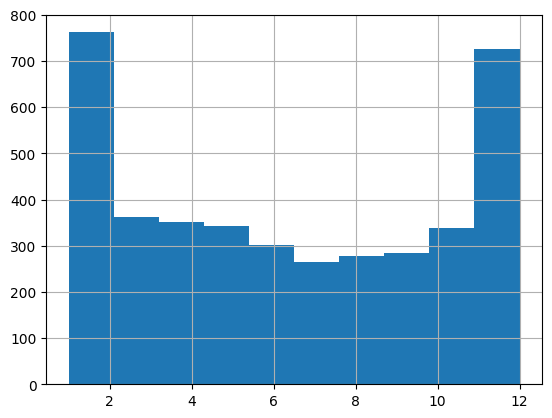

In [161]:
y_overunder.hist()

In [166]:
# Map resampled class labels back to scores
y_train_resampled = y_overunder / 2.0

In [168]:
# Normalising the data
# More info: https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe

from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_overunder)
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_overunder.columns)
X_train_normalized.head()


,word_count,event_count,text_changes_per_min,sentence_count,Remove/Cut_count,Paste_count,Replace_count,Nonproduction_count,pauses_count,pause_mean_duration,pauses_time_sum,writing_time_ms,pauses_share,start_time,total_writing_time,Avg_time_between_events,overtime_writing,average_action_time,most_frequent_activity_Input,most_frequent_activity_Nonproduction
0,0.389992,0.329826,0.341594,0.414634,0.195129,0.0,0.000000,0.019709,0.260000,0.017623,0.173575,0.299497,0.386364,0.002432,0.305057,0.072011,0.0,0.285226,1.0,0.0
1,0.131056,0.175918,0.162320,0.195122,0.168696,0.0,0.000000,0.034840,0.377143,0.016713,0.242767,0.305973,0.545455,0.002003,0.311722,0.158024,0.0,0.496442,1.0,0.0
2,0.185068,0.268134,0.289279,0.317073,0.306504,0.0,0.000000,0.013538,0.211429,0.027989,0.194436,0.287523,0.454545,0.035610,0.287163,0.088012,0.0,0.639126,1.0,0.0
3,0.227164,0.158487,0.150619,0.219512,0.035343,0.0,0.030097,0.019510,0.257143,0.030368,0.249330,0.306473,0.568182,0.035976,0.306398,0.172731,0.0,0.285790,1.0,0.0
4,0.172359,0.134469,0.116781,0.268293,0.035343,0.0,0.000000,0.053155,0.180000,0.052427,0.274521,0.298443,0.636364,0.032706,0.298778,0.197775,0.0,0.597694,1.0,0.0


In [170]:
X_val_normalized = scaler.transform(X_val)
X_val_normalized = pd.DataFrame(X_val_normalized, columns=X_val.columns)
# X_val_normalized.head()

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# from xgboost import XGBClassifier
# from sklearn.preprocessing import LabelEncoder

# # Transforming the scores by multiplying by 2 to convert them into integers
# y_train_transformed = (y_train * 2).astype(int)
# y_test_transformed = (y_test * 2).astype(int)

# label_encoder_transformed = LabelEncoder()
# y_train_transformed_encoded = label_encoder_transformed.fit_transform(y_train_transformed)
# y_test_transformed_encoded = label_encoder_transformed.transform(y_test_transformed)

# class_weights_transformed_encoded = compute_class_weight(
#     class_weight='balanced', 
#     classes=np.unique(y_train_transformed_encoded), 
#     y=y_train_transformed_encoded
# )
# class_weights_dict_transformed_encoded = dict(
#     zip(np.unique(y_train_transformed_encoded), class_weights_transformed_encoded)
# )

# sample_weights_transformed_encoded = [
#     class_weights_dict_transformed_encoded[label] for label in y_train_transformed_encoded
# ]

# xgb_classifier_transformed_encoded = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# xgb_classifier_transformed_encoded.fit(X_train, y_train_transformed_encoded, sample_weight=sample_weights_transformed_encoded)


In [ ]:
# y_pred_transformed_encoded = xgb_classifier_transformed_encoded.predict(X_test)
# y_pred = label_encoder_transformed.inverse_transform(y_pred_transformed_encoded) / 2

In [ ]:
# from sklearn.metrics import mean_squared_error
# import numpy as np
# # Root Mean Squared Error (RMSE)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# rmse

In [ ]:
# import lightgbm as lgb
# from sklearn.preprocessing import LabelEncoder

# y_train_transformed = (y_train * 2).astype(int)
# y_test_transformed = (y_test * 2).astype(int)

# label_encoder_transformed = LabelEncoder()
# y_train_transformed_encoded = label_encoder_transformed.fit_transform(y_train_transformed)
# y_test_transformed_encoded = label_encoder_transformed.transform(y_test_transformed)

# num_classes = len(np.unique(y_train_transformed_encoded))
# lgbm_classifier = lgb.LGBMClassifier(objective='multiclass', num_class=num_classes)

# lgbm_classifier.fit(X_train, y_train_transformed_encoded)

# y_pred_transformed_encoded = lgbm_classifier.predict(X_test)
# y_pred = y_pred_transformed_encoded / 2.0

# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# rmse

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'num_leaves': [31, 63, 127],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'lambda_l1': [0, 0.1, 1],
#     'lambda_l2': [0, 0.1, 1],
# }

# # Initialize LightGBM classifier
# lgbm_classifier = lgb.LGBMClassifier(objective='multiclass', num_class=num_classes)

# grid_search = GridSearchCV(estimator=lgbm_classifier, param_grid=param_grid, cv=5)

# grid_search.fit(X_train, y_train_transformed_encoded)

# best_params = grid_search.best_params_

# best_lgbm_classifier = lgb.LGBMClassifier(objective='multiclass', num_class=num_classes, **best_params)
# best_lgbm_classifier.fit(X_train, y_train_transformed_encoded)

# y_pred_transformed_encoded = best_lgbm_classifier.predict(X_test)
# y_pred = y_pred_transformed_encoded / 2.0

# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# rmse

# Train labels (essay grades)


In [32]:
df_labels = pd.read_csv("../data/train_scores.csv")
df_labels.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


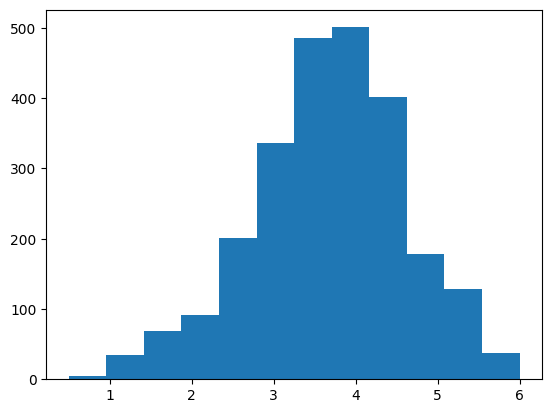

In [171]:
import matplotlib.pyplot as plt

plt.hist(df_labels['score'], bins = 12)
plt.show()

<Axes: xlabel='score'>

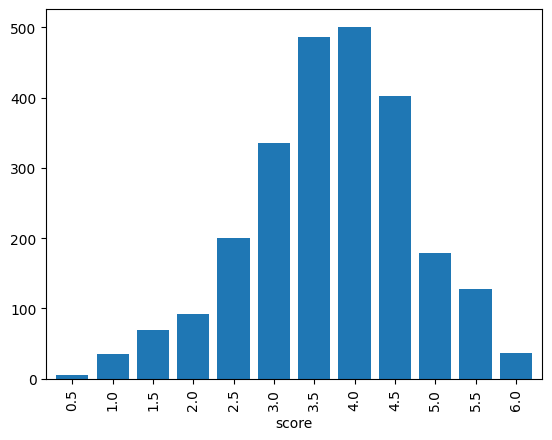

In [34]:
df_labels.groupby('score')['id'].count().plot.bar(width =0.8)